In [1]:
import cv2
import os
import h5py
from tqdm.notebook import tqdm
import numpy as np
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
st = time.time()
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    print(F.keys())
    images = np.array(F['images'])
    labels = np.array(F['ans'])
print(f"Time: {time.time() - st}")
images.shape

<KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>
Time: 46.852994203567505


(17736, 256, 256, 3)

Zmiana rozdzielczości obrazów

In [3]:
imgSize = 128
X = np.zeros((images.shape[0], imgSize, imgSize, 3), dtype=int)
for i in tqdm(range(images.shape[0])):
    X[i] = cv2.resize(images[i], (imgSize, imgSize))
images.shape, X.shape

  0%|          | 0/17736 [00:00<?, ?it/s]

((17736, 256, 256, 3), (17736, 128, 128, 3))

  0%|          | 0/10 [00:00<?, ?it/s]

[Text(0.5, 0, 'Klasy według sekwencji Hubbla'),
 Text(0, 0.5, 'Oryginalne klasy datasetu galaktyk astroNN'),
 Text(0.5, 1.0, 'Zamiana oryginalnych klas galaktyk na sekwencję Hubbla')]

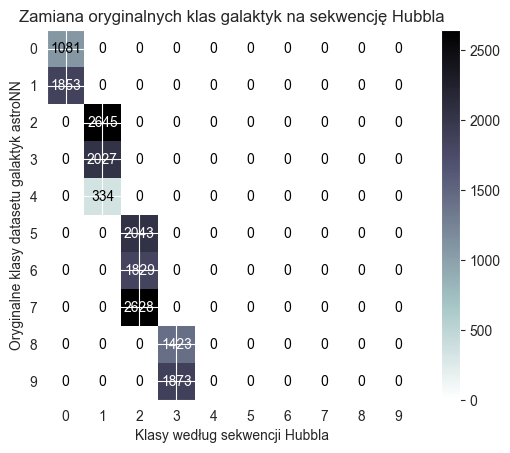

In [4]:
Y = labels.copy()
mapping = {
    0: 0,
    1: 0,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: 2,
    8: 3,
    9: 3
}

for i in tqdm(range(10)):
    Y[labels == i] = mapping[i]

cm = confusion_matrix(labels, Y, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(labels))
disp.plot(cmap='bone_r')  # BuPu, bone_r
disp.ax_.set(xlabel="Klasy według sekwencji Hubbla", ylabel="Oryginalne klasy datasetu galaktyk astroNN",
             title='Zamiana oryginalnych klas galaktyk na sekwencję Hubbla')

Podział zbioru na treningowy i testowy

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((11883, 128, 128, 3), (5853, 128, 128, 3), (11883,), (5853,))

Utworzenie funkcji do edycji obrazu przez wyrównanie histogramu oraz zastosowanie filtru medianowego

In [6]:
def histogram_equalization(img):
    rgb_img = img.astype('uint8')
    img_hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
    imag = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return imag.copy()


def filterFunction(img):
    return cv2.medianBlur(img.astype('uint8'), 7).copy()
    #return cv2.GaussianBlur(img.astype('uint8'), (5,5), 0).copy()

Utworzenie ścieżek dla obrazów

In [7]:
imagesPath = 'trainData'
testPath = 'testData'
types = ['original', 'histogram', 'filter']

for t in types:

    if t not in os.listdir():
        os.mkdir(t)

    for path in [imagesPath, testPath]:
        if path not in os.listdir(f'{t}/'):
            os.mkdir(f'{t}/{path}')

        for i in range(4):
            p = f'{t}/{path}/{i}'
            if str(i) not in os.listdir(f'{t}/{path}/'):
                os.mkdir(p)

Zapisywanie obrazów

In [8]:
n = 0
k = range(X_train.shape[0])
for i in tqdm(k):
    img = X_train[i].copy()
    imgHist = histogram_equalization(img)
    imgGaus = filterFunction(img)

    image_ = np.expand_dims(img, axis=0)
    #print(image_.shape)
    imgen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='wrap',  # 'wrap', 'nearest', 'reflect', 'constant' # pewnie reflect albo constant
        rotation_range=180,
        horizontal_flip=True,
        vertical_flip=True
    )

    img_train = imgen.flow(image_, batch_size=1)

    filename = f"original/{imagesPath}/{Y_train[i]}/{len(os.listdir(f'original/{imagesPath}/{Y_train[i]}')) + 1}.png"  # folder + label + branie ostatniej cyfry w tym folderze + 1
    filenameHist = f"histogram/{imagesPath}/{Y_train[i]}/{len(os.listdir(f'histogram/{imagesPath}/{Y_train[i]}')) + 1}.png"  # dla wyrównanych po histogramie
    filenameGaus = f"filter/{imagesPath}/{Y_train[i]}/{len(os.listdir(f'filter/{imagesPath}/{Y_train[i]}')) + 1}.png"  # dla filtru
    cv2.imwrite(filename, img)
    cv2.imwrite(filenameHist, imgHist)
    cv2.imwrite(filenameGaus, imgGaus)

    for j in range(n):  # generwoanie dodatkowych obrazów
        filename = f"original/{imagesPath}/{Y_train[i]}/{len(os.listdir(f'original/{imagesPath}/{Y_train[i]}')) + 1}.png"
        filenameHist = f"histogram/{imagesPath}/{Y_train[i]}/{len(os.listdir(f'histogram/{imagesPath}/{Y_train[i]}')) + 1}.png"
        filenameGaus = f"filter/{imagesPath}/{Y_train[i]}/{len(os.listdir(f'filter//{imagesPath}/{Y_train[i]}')) + 1}.png"

        newImg = img_train.next()[0]
        newImgHist = histogram_equalization(newImg)
        newImgGaus = filterFunction(newImg)

        cv2.imwrite(filename, newImg)
        cv2.imwrite(filenameHist, newImgHist)
        cv2.imwrite(filenameGaus, newImgGaus)

k = range(X_test.shape[0])
for i in tqdm(k):
    img = X_test[i].copy()
    imgHist = histogram_equalization(img)
    imgGaus = filterFunction(img)

    filename = f"original/{testPath}/{Y_test[i]}/{len(os.listdir(f'original/{testPath}/{Y_test[i]}')) + 1}.png"
    filenameHist = f"histogram/{testPath}/{Y_test[i]}/{len(os.listdir(f'histogram//{testPath}/{Y_test[i]}')) + 1}.png"
    filenameGaus = f"filter/{testPath}/{Y_test[i]}/{len(os.listdir(f'filter/{testPath}/{Y_test[i]}')) + 1}.png"

    cv2.imwrite(filename, img)
    cv2.imwrite(filenameHist, imgHist)
    cv2.imwrite(filenameGaus, imgGaus)

  0%|          | 0/11883 [00:00<?, ?it/s]

  0%|          | 0/5853 [00:00<?, ?it/s]

In [9]:

for t in ['original', 'histogram', 'filter']:
    biggestClass = 0
    bcValue = 0
    for i in range(4):
        if len(os.listdir(f'{t}/{imagesPath}/{i}')) > bcValue:
            bcValue = len(os.listdir(f'{t}/{imagesPath}/{i}'))
            biggestClass = i

    for i in range(4):
        if i != biggestClass:

            k = range(bcValue - len(os.listdir(f'{t}/{imagesPath}/{i}')))
            print(f"type: {t}, class: {i}")
            for j in tqdm(k):
                image = img_to_array(load_img(f"{t}/{imagesPath}/{i}/{np.random.randint(1, len(os.listdir(f'{t}/{imagesPath}/{i}')))}.png"))
                image_ = np.expand_dims(image, axis=0)
                #print(image_.shape)

                imgen = ImageDataGenerator(
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    fill_mode='wrap',  # 'wrap', 'nearest', 'reflect', 'constant' # pewnie reflect albo constant
                    rotation_range=180,
                    brightness_range=[0.45, 1],  # nad tym się zastanawiam
                    horizontal_flip=True,
                    vertical_flip=True
                )

                img_train = imgen.flow(image_, batch_size=1)
                filename = f"{t}/{imagesPath}/{i}/{len(os.listdir(f'{t}/{imagesPath}/{i}')) + 1}.png"
                newImg = img_train.next()[0]
                cv2.imwrite(filename, newImg)


type: original, class: 0


  0%|          | 0/2361 [00:00<?, ?it/s]

type: original, class: 1


  0%|          | 0/997 [00:00<?, ?it/s]

type: original, class: 3


  0%|          | 0/2139 [00:00<?, ?it/s]

type: histogram, class: 0


  0%|          | 0/2361 [00:00<?, ?it/s]

type: histogram, class: 1


  0%|          | 0/997 [00:00<?, ?it/s]

type: histogram, class: 3


  0%|          | 0/2139 [00:00<?, ?it/s]

type: filter, class: 0


  0%|          | 0/2361 [00:00<?, ?it/s]

type: filter, class: 1


  0%|          | 0/997 [00:00<?, ?it/s]

type: filter, class: 3


  0%|          | 0/2139 [00:00<?, ?it/s]

In [6]:
for t in ['original', 'histogram', 'filter']:
    for i in range(4):
        print(f"{i}: {len(os.listdir(f'{t}/{imagesPath}/{i}'))}")

0: 8659
1: 8659
2: 8659
3: 8659
0: 8659
1: 8659
2: 8659
3: 8659
0: 8659
1: 8659
2: 8659
3: 8659


In [10]:
imgSize = 128

galaxy_test =[]#np.zeros((25, imgSize, imgSize, 3), dtype=int)
galaxy_labels = []
print("Zbieranie obrazów galaktyk")
for i in tqdm(range(4)):
    for j in range(len(os.listdir(f'galaktyki_test/{i}'))):
        img  = img_to_array(load_img(f"galaktyki_test/{i}/{j}.png")).astype('uint8')
        galaxy_test.append(cv2.resize(img, (imgSize, imgSize)))
        galaxy_labels.append(i)


print("Zapisywanie sformatowanych obrazów galaktyk")
for t in tqdm(['original', 'hist', 'filter']):
    if t not in os.listdir(f'galaktyki_test/'):
        os.mkdir(f'galaktyki_test/{t}')
        for i in range(4):
            p = f'galaktyki_test/{t}/{i}'
            if str(i) not in os.listdir(f'galaktyki_test/{t}/'):
                os.mkdir(p)
    for i in range(len(galaxy_labels)):

        filename = f"galaktyki_test/{t}/{galaxy_labels[i]}/{len(os.listdir(f'galaktyki_test/{t}/{galaxy_labels[i]}/')) + 1}.png"
        if t == 'hist':
            cv2.imwrite(filename, histogram_equalization(galaxy_test[i]))
        elif t == 'filter':
            cv2.imwrite(filename, filterFunction(galaxy_test[i]))
        else:
            cv2.imwrite(filename, galaxy_test[i])


Zbieranie obrazów galaktyk


  0%|          | 0/4 [00:00<?, ?it/s]

Zapisywanie sformatowanych obrazów galaktyk


  0%|          | 0/3 [00:00<?, ?it/s]